In [0]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile


In [0]:
# this code will mount the google drive with colabs.
# Skip this step if you have GPU and have data in local directory
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def copySourceToDest(source_list, source_path, destination_path):
  """
  This function takes images source list, source path string, destination path string
  and copy the image from source path to destination path
  """
  for image in source_list:
    shutil.copy('{}{}'.format(source_path,image), destination_path)


In [0]:
import os
import shutil
from random import shuffle

# I have uploaded data from google drive to google colabs, you can directly load the data from zip file


# # <-- Code to read the file from google drive and extracting it in local path -->
file_path = 'cell-images-for-detecting-malaria.zip'
# statinfo = os.stat(file_path)
# statinfo.st_size

zfile = zipfile.ZipFile(file_path)
zfile.extractall('temp-dataset')
# # <-- Code to read the file from google drive and extracting it in local path -->



# Remove the file tree
# shutil.rmtree('dataset')



# <--- Create directories --->
os.mkdir('dataset')
os.mkdir('dataset/training_set')
os.mkdir('dataset/training_set/parasitized')
os.mkdir('dataset/test_set')
os.mkdir('dataset/test_set/parasitized')
os.mkdir('dataset/training_set/uninfected')
os.mkdir('dataset/test_set/uninfected')
# <--- Create directories --->

# <------ This code starts from here ---->
parasitized_filelist = os.listdir('temp-dataset/cell_images/Parasitized')
parasitized_filelist

uninfected_filelist = os.listdir('temp-dataset/cell_images/Uninfected')
uninfected_filelist[0]

shuffle(parasitized_filelist)
shuffle(uninfected_filelist)

train_paras_list = parasitized_filelist[0:11024]
test_paras_list = parasitized_filelist[11024:]
train_uninf_list = uninfected_filelist[0:11024]
test_uninf_list  = uninfected_filelist[11024:]


copySourceToDest(train_paras_list, 'temp-dataset/cell_images/Parasitized/', 
                 'dataset/training_set/parasitized')
copySourceToDest(test_paras_list, 'temp-dataset/cell_images/Parasitized/', 
                 'dataset/test_set/parasitized')
copySourceToDest(train_uninf_list, 'temp-dataset/cell_images/Uninfected/', 
                 'dataset/training_set/uninfected')
copySourceToDest(test_uninf_list, 'temp-dataset/cell_images/Uninfected/', 
                 'dataset/test_set/uninfected')
# <------ This code ends here ---->





Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)   
        #RELU Activation
        self.relu = nn.ReLU()                 
        #Maxpooling reduces the size by kernel size. 64/2 = 32
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    
        
        #Flatten the feature maps. 
        #Flattened image is fed into linear NN and reduced to half size
        self.fc1 = nn.Linear(in_features=8192, out_features=4000)   
        #Dropout used to reduce overfitting
        self.droput = nn.Dropout(p=0.5)                    
        self.fc2 = nn.Linear(in_features=4000, out_features=2000)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=2000, out_features=500)
        self.droput = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=500, out_features=50)
        self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=50, out_features=2)    
       
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,8192)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc5(out)
        return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


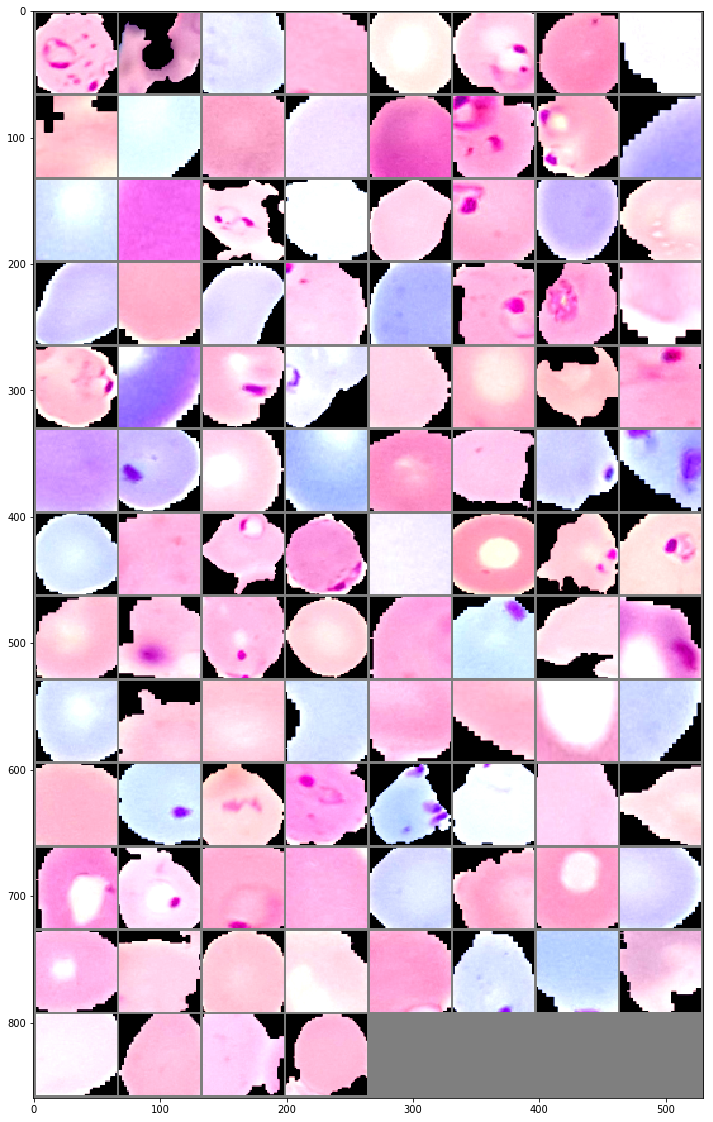

In [0]:
#Transformation for image
transform_ori = transforms.Compose([transforms.RandomResizedCrop(64),   #create 64x64 image
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    
#Loading  dataset
train_dataset = datasets.ImageFolder(root = 'dataset/training_set',
                                     transform = transform_ori)

test_dataset = datasets.ImageFolder(root = 'dataset/test_set',
                                    transform = transform_ori)


#Making the dataset iterable
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)     

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)
                                         
#Show a batch of images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [0]:
#Training the CNN
%%time
import time

num_epochs = 32

#Defining the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data      # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.data
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

Epoch 1/32, Training Loss: 0.693, Training Accuracy: 51.000, Testing Loss: 0.025, Testing Acc: 60.000, Time: 31.965874195098877s
Epoch 2/32, Training Loss: 0.689, Training Accuracy: 55.000, Testing Loss: 0.026, Testing Acc: 60.000, Time: 31.218397855758667s
Epoch 3/32, Training Loss: 0.673, Training Accuracy: 60.000, Testing Loss: 0.027, Testing Acc: 66.000, Time: 31.21279740333557s
Epoch 4/32, Training Loss: 0.635, Training Accuracy: 66.000, Testing Loss: 0.023, Testing Acc: 69.000, Time: 31.591642141342163s
Epoch 5/32, Training Loss: 0.611, Training Accuracy: 69.000, Testing Loss: 0.024, Testing Acc: 72.000, Time: 31.161758184432983s
Epoch 6/32, Training Loss: 0.577, Training Accuracy: 72.000, Testing Loss: 0.030, Testing Acc: 73.000, Time: 31.360894680023193s
Epoch 7/32, Training Loss: 0.527, Training Accuracy: 76.000, Testing Loss: 0.023, Testing Acc: 76.000, Time: 31.214304208755493s
Epoch 8/32, Training Loss: 0.472, Training Accuracy: 78.000, Testing Loss: 0.011, Testing Acc: 80.

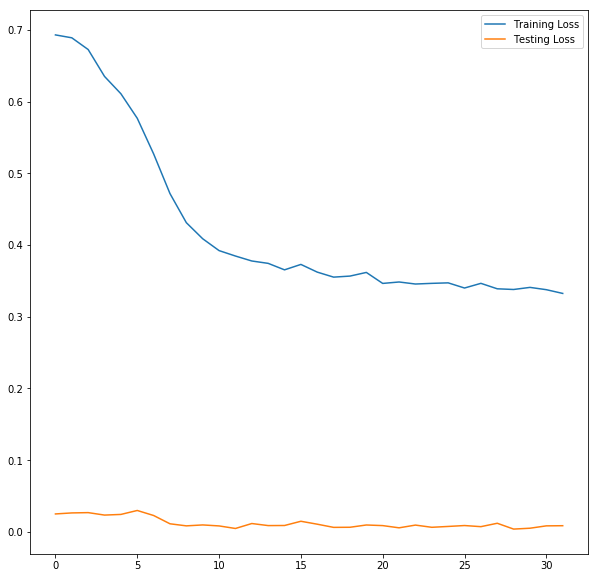

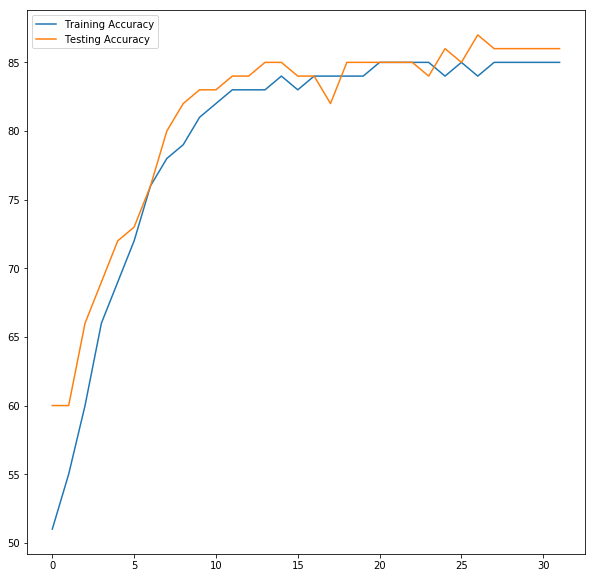

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

#Run this if you want to save the model
torch.save(model.state_dict(),'Malaria.pth')

#Run this if you want to load the model
model.load_state_dict(torch.load('Malaria.pth'))

In [0]:
def transforms_photo(inp):
    """
    This function takes the image array as input returns the tranformed image 
    """
    out = transforms.functional.resize(inp, [64,64])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

<PIL.Image.Image image mode=RGB size=118x103 at 0x7F4231FD45C0>
tensor([[ 1.8973, -1.9299]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 1.8973, -1.9299]], device='cuda:0')


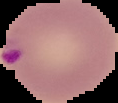

The Predicted Label is Parasitized
<PIL.Image.Image image mode=RGB size=145x136 at 0x7F423D0B65C0>
tensor([[-1.0789,  1.1384]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-1.0789,  1.1384]], device='cuda:0')


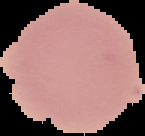

The Predicted Label is Uninfected


In [0]:
# This library is needed for colabs
from google.colab.patches import cv2_imshow
def predict(img_name,model):
    image = cv2.imread(img_name)   #Read the image
    img = Image.fromarray(image)      #Convert the image to an array
    print(img)
    
#     img = transforms.ToTensor()(img)
#     print(img.shape)
    img = transforms_photo(img)     #Apply the transformations 
    img = img.view(1,3,64,64)       #Add batch size 
    img = Variable(img)      
    #Wrap the tensor to a variable
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    if predicted.item()==0:
        p = 'Parasitized'
    else:
        p = 'Uninfected'
    cv2_imshow(image)
    return  p
    
    
# making  prediction    
parasitized_filelist = os.listdir('dataset/test_set/parasitized')
uninfected_filelist = os.listdir('dataset/test_set/uninfected')

pred = predict('temp-dataset/cell_images/Parasitized/{}'.format(parasitized_filelist[70]), model)
print("The Predicted Label is {}".format(pred))  

pred = predict('temp-dataset/cell_images/Uninfected/{}'.format(uninfected_filelist[125]), model)
print("The Predicted Label is {}".format(pred))  




In [0]:
# Reference used for this project 
# Udacity Introduction to pytorch free course.
# https://medium.com/@vivekvscool/image-classification-cnn-with-pytorch-5b2cb9ef9476
# Souce of dataset- https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria